## 02 - festom-exploration.ipynb

### Table of content


In [1]:
import netCDF4 as nc
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from tqdm import tqdm
from datetime import timedelta

In [2]:
path_base = "C:\\Users\\Fedor Stomakhin\\Downloads\\waterhypernet\\hypstar\\processed20230317\\LVES\\2023\\"

In [3]:
def get_all_nc_paths(path_base):
    paths = []
    for folder_month in os.listdir(path_base):
        path_month = os.path.join(path_base, folder_month)
        for folder_day in os.listdir(path_month):
            path_day = os.path.join(path_month, folder_day)
            for folder_time in os.listdir(path_day):
                path_time = os.path.join(path_day, folder_time)
                nc_files = [fname for fname in os.listdir(path_time) if fname[-3:] == ".nc"]
                if len(nc_files) > 0:
                    paths.append(os.path.join(path_time, nc_files[0]))
    return paths

In [ ]:
metadata = ['sequence_id', 'system_id', 'site_id', 'site_latitude', 'site_longitude', 'source_file', 'system_temperature', 'system_pressure', 'illuminance', 'system_relative_humidity','fresnel_option', 'similarity_waveref', 'similarity_wavethres', 'similarity_wavelen1', 'similarity_wavelen2', 'similarity_alpha', 'instrument_calibration_file_rad', 'IRR_acceleration_x_mean', 'IRR_acceleration_x_std', 'ss_res', 'product_level']
variables = ['wavelength', 'reflectance', "acquisition_time"]


def read_nc_file(fullpath: str):
    ds = nc.Dataset(fullpath)
    s_metadata = pd.Series(ds.__dict__)[metadata]
    s_data = pd.Series()
    s_data["acquisition_time"] = pd.to_datetime(ds.variables["acquisition_time"][0], unit="s")
    s_data["wavelength"] = ds.variables["wavelength"][:]
    s_data["reflectance"] = np.reshape(ds.variables["reflectance"][:], -1)
    return s_metadata, s_data

In [5]:
paths = get_all_nc_paths(path_base)
metas = []
datas = []
for i in tqdm(range(len(paths))):
    path = paths[i]
    s_meta, s_data = read_nc_file(path)
    metas.append(s_meta)
    datas.append(s_data)


In [8]:
pd.DataFrame(datas).to_parquet("nc_reflectance_data.parquet")
pd.DataFrame(metas).to_parquet("nc_reflectance_metadata.parquet")

## Preliminary analysis and data exploration

In [9]:
df = pd.read_parquet("nc_reflectance_data.parquet")

In [85]:
color_to_wavelength = {
    "red": 650,
    "green": 550,
    "blue": 450
}
def wavelength_to_range(l, width=20):
    return [l-width/2, l+width/2]
def wavelength_range_mask(w_series, w_from, w_to):
    return (w_series > w_from) & \
           (w_series < w_to)
def get_mean_reflectance_color(color, reflectances, wavelengths):
    wavelength = color_to_wavelength[color]
    w_range = wavelength_to_range(wavelength)
    w_range_mask = wavelength_range_mask(wavelengths, *w_range)
    mean_reflectance = reflectances[w_range_mask].mean()
    return mean_reflectance

In [87]:
color_cols = []
for color in color_to_wavelength.keys():
    col = f"reflectance_mean_{color}"
    df[col] = df[["reflectance", "wavelength"]].apply(lambda row: get_mean_reflectance_color(color, row["reflectance"], row["wavelength"]), axis=1)
    color_cols.append(col)

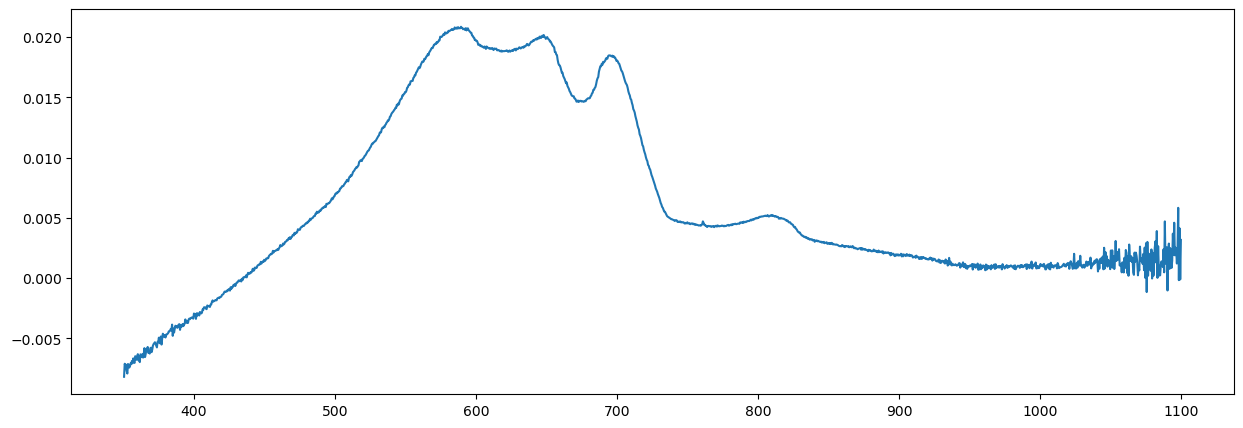

In [31]:
plt.plot("wavelength", "reflectance", data=(df[["wavelength", "reflectance"]].iloc[0]))
plt.show()

In [10]:
df["mean_neg_reflectance_present"] = df["reflectance"].apply(lambda row: (row < 0).mean())

In [54]:
df["reflectance_q05"] = df["reflectance"].apply(lambda vec: np.quantile(vec, .05))
df["reflectance_q95"] = df["reflectance"].apply(lambda vec: np.quantile(vec, .95))
df["reflectance_mean"] = df["reflectance"].apply(lambda vec: np.mean(vec))

In [91]:
month_day_group_idx = df["acquisition_time"].dt.month + df["acquisition_time"].dt.day/30
hour_minute_group_idx = df["acquisition_time"].dt.hour+df["acquisition_time"].dt.minute//15/4

<Axes: xlabel='acquisition_time'>

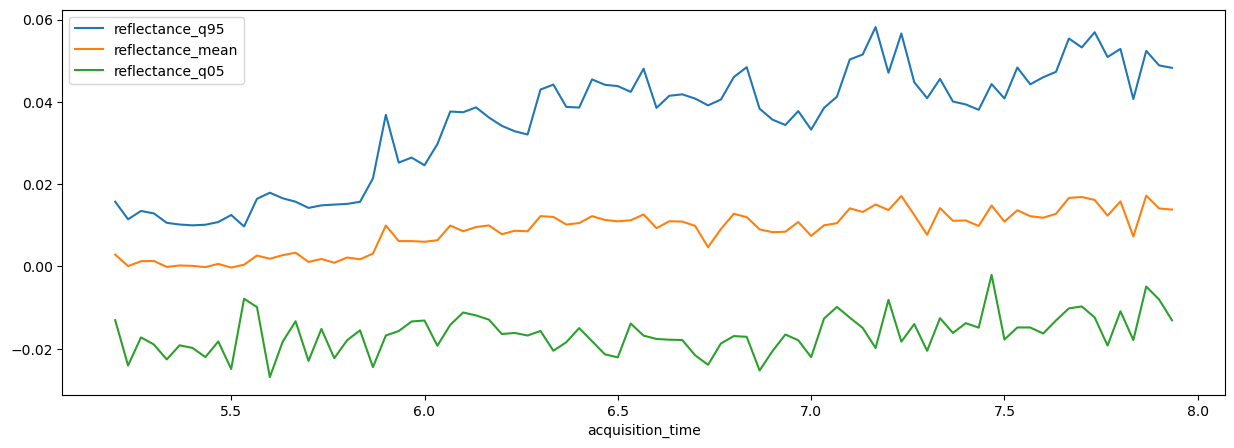

In [92]:
df.groupby(month_day_group_idx).mean("reflectance_95")[["reflectance_q95", "reflectance_mean", "reflectance_q05"]].plot()

<Axes: xlabel='acquisition_time'>

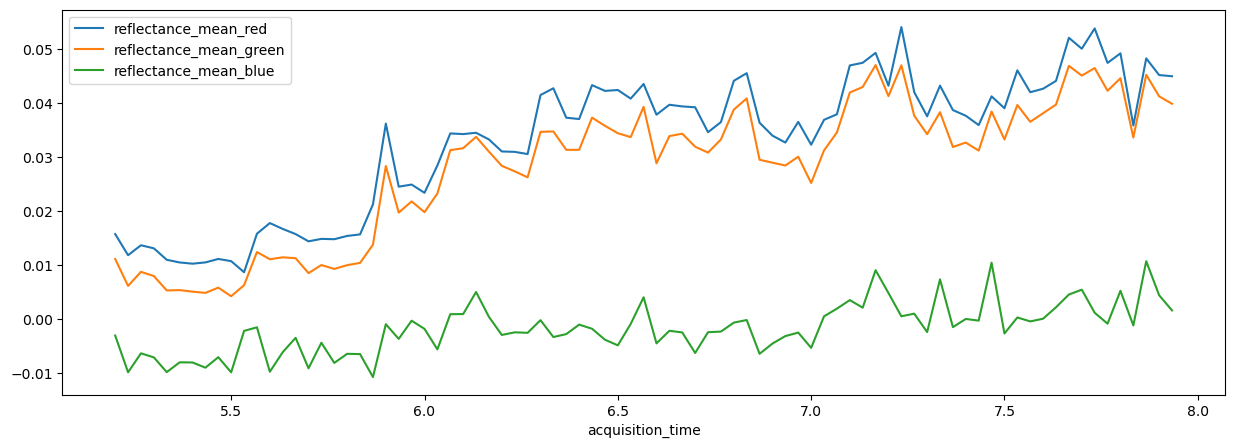

In [93]:
df.groupby(month_day_group_idx).mean("reflectance_95")[color_cols].plot()

<Axes: xlabel='acquisition_time'>

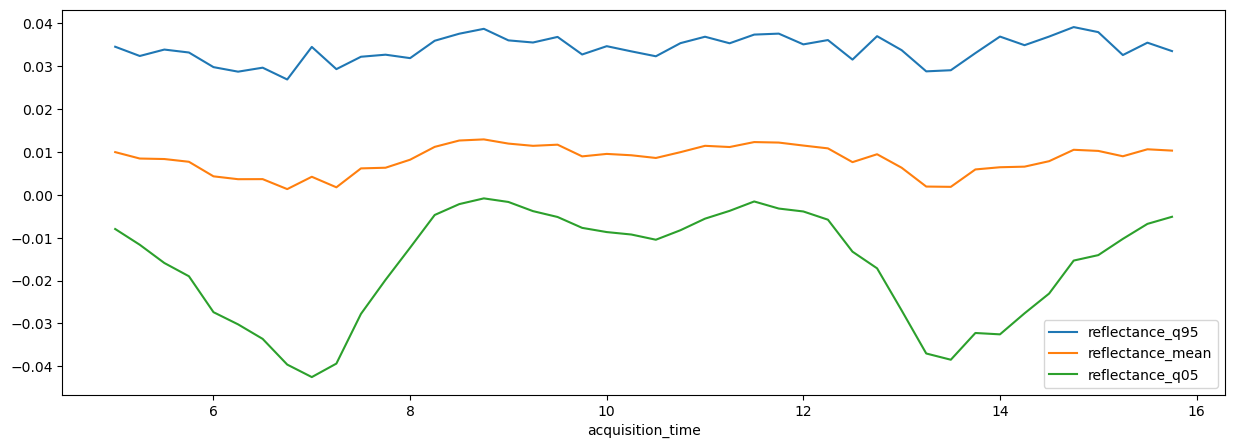

In [94]:
df.groupby(hour_minute_group_idx).mean("reflectance_95")[["reflectance_q95", "reflectance_mean", "reflectance_q05"]].plot()

<Axes: xlabel='acquisition_time'>

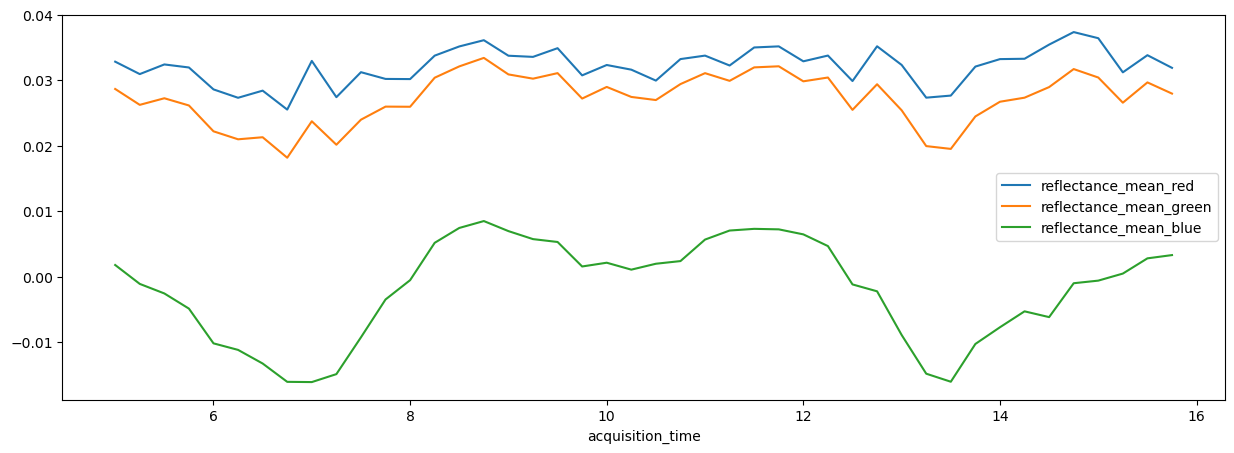

In [95]:
df.groupby(hour_minute_group_idx).mean("reflectance_95")[color_cols].plot()

<Axes: xlabel='acquisition_time'>

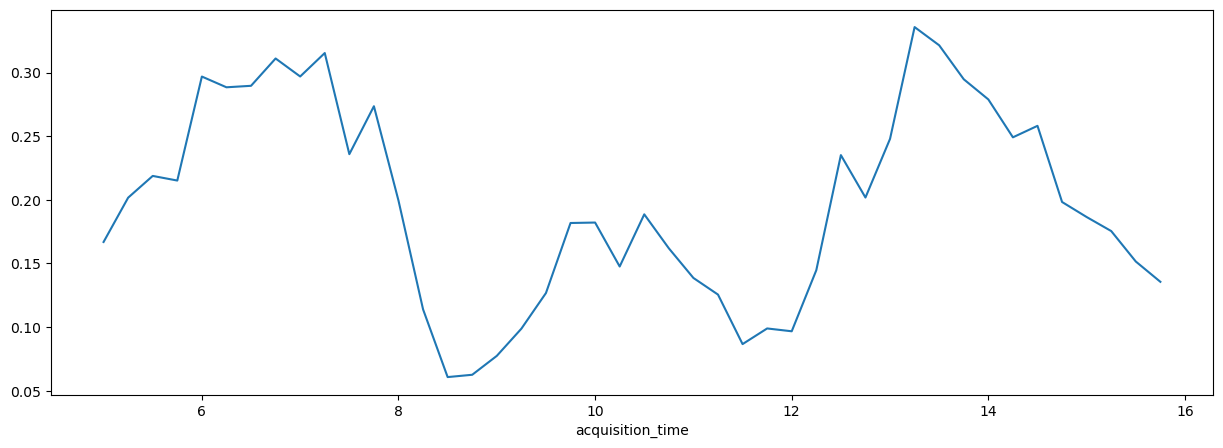

In [60]:
df.groupby(df["acquisition_time"].dt.hour+df["acquisition_time"].dt.minute//15/4).mean("mean_neg_reflectance_present")["mean_neg_reflectance_present"].plot()

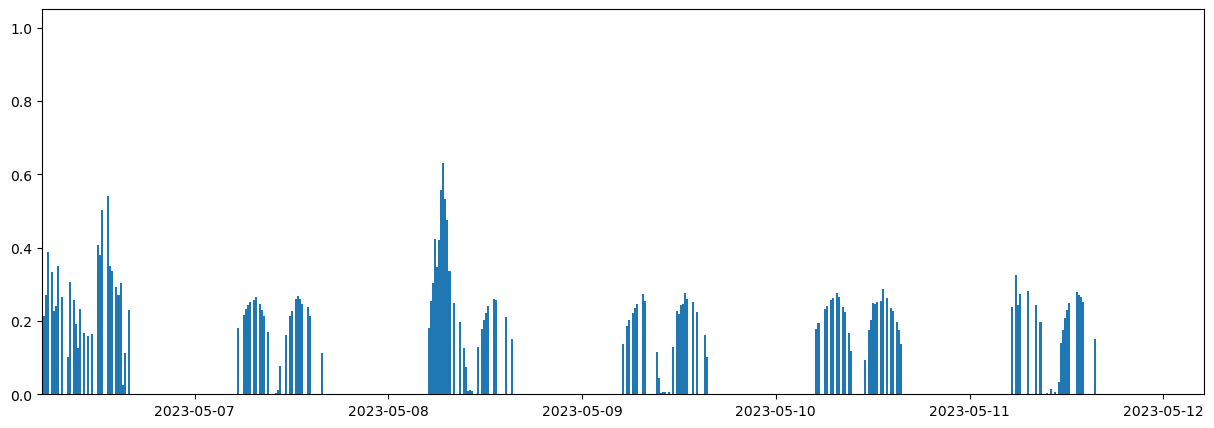

In [13]:
plt.rcParams["figure.figsize"] = 15, 5
plt.bar(df["acquisition_time"], df["mean_neg_reflectance_present"], width=timedelta(minutes=15))
plt.xlim(left=df["acquisition_time"].min(), right=df["acquisition_time"].min() + timedelta(days=6))
plt.show()